# Project 2 – Group 34
## Dataset: Heart Failure Clinical Records
**Source:** [UCI Machine Learning Repository](https://doi.org/10.24432/C5Z89R)
 
> This dataset contains the medical records of 299 patients who experienced heart failure, collected during their follow-up period. Each patient profile includes 13 clinical features.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt


# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# transformations
def identity(x): return x
def log(x): return np.log(x + 1e-6)   # undgå log(0)
def sqrt(x): return np.sqrt(np.clip(x, 0, None))  # sqrt kræver >=0
def reciprocal(x): return 1.0 / (x + 1e-6)  # undgå /0





## Classification: Baseline, Logistic Regression, and KNN
We will compare three classification methods on the heart failure dataset:
- Baseline (majority class)
- Logistic Regression (with regularization)
- k-Nearest Neighbors (KNN)
Performance will be evaluated using accuracy and cross-validation.

Loading and cleaning the dataset from the outcome of hand_in 1

In [ ]:
df = pd.read_csv('../02452_Group34_Project1/data/heart_failure_clinical_records_dataset.csv')

X = df.drop(columns=['DEATH_EVENT', 'time'])         # Features without target and time
y = pd.Categorical(df['DEATH_EVENT'])        # Target as categorical

# Check the shape of the data
N, M = X.shape
assert N == 299, "There should be 299 samples in the Heart Failure dataset."
assert M == 11, "There should be 11 features in the Heart Failure dataset(13 together - target - time)"

#Transform the chosen features 
X_transformed = X.copy()
X_transformed['creatinine_phosphokinase'] = log(X_transformed['creatinine_phosphokinase'])
X_transformed['platelets'] = sqrt(X_transformed['platelets'])
X_transformed['serum_creatinine'] = reciprocal(X_transformed['serum_creatinine'])

X = X_transformed

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

X = X_standardized

### 1. Classification Problem Statement
We are solving a **binary classification problem**: predicting whether a patient died during the follow-up period (`DEATH_EVENT` = 1) or survived (`DEATH_EVENT` = 0). The target variable is binary, so this is not a multi-class problem.

we are gonna do baseline, logistic regression and KNN, in the code nlock bellow we make just first draft of classifier with random paramters

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

# Baseline: predict the majority class
def baseline_accuracy(y):
    majority_class = y.value_counts().idxmax()
    y_pred_baseline = np.full_like(y, majority_class)
    return accuracy_score(y, y_pred_baseline)

baseline_acc = baseline_accuracy(y)
print(f'Baseline accuracy (majority class): {baseline_acc:.3f}')

# Logistic Regression with regularization (lambda = C^-1)
logreg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_scores = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')
print(f'Logistic Regression CV accuracy: {logreg_scores.mean():.3f} ± {logreg_scores.std():.3f}')

# KNN classification (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
print(f'KNN (k=5) CV accuracy: {knn_scores.mean():.3f} ± {knn_scores.std():.3f}')

Baseline accuracy (majority class): 0.679
Logistic Regression CV accuracy: 0.736 ± 0.069
KNN (k=5) CV accuracy: 0.676 ± 0.034


They do not perform the best, so from first simple classification Logistic regression for classfication performs the best, lets do some cross-validation to tune the paramters

### 2. Models and Complexity Parameters
- **Logistic Regression**: We use the regularization parameter λ (lambda) to control model complexity. In scikit-learn, this is set via `C = 1/λ`. We will test values such as λ ∈ {0.01, 0.05, 0.1, 0.5, 1.0} (i.e., C ∈ {100, 20, 10, 2, 1}).
- **Method 2 (KNN)**: The complexity parameter is the number of neighbors, k. We will test k ∈ {1, 3, 5, 7, 9}.
- **Baseline**: Always predicts the majority class in the training data.

For our analysis, we will compare three different models: a baseline model, a K-Nearest Neighbors (KNN) classifier, and a Logistic Regression classifier.

**1. Baseline Model:**
The baseline model serves as a simple benchmark to evaluate the performance of the more complex models. It operates by identifying the majority class in the training data and then predicting that all instances in the test data belong to this class. This corresponds to the optimal prediction for a model with only a bias term and no features, providing a minimum performance threshold that any useful model should exceed.

**2. K-Nearest Neighbors (KNN):**
The complexity of the KNN model is determined by the number of neighbors, `k`. A small `k` makes the model more complex and sensitive to local variations (potentially leading to overfitting), while a large `k` makes it simpler and more robust to noise (potentially leading to underfitting). We will examine the following possible values for `k`: `[1, 3, 5, 7, 9, 12, 15, 20, 30, 40]`.

**3. Logistic Regression:**
For Logistic Regression, the complexity is controlled by the regularization parameter, `C`. This parameter is the inverse of the regularization strength `λ` (i.e., `C = 1/λ`). A smaller `C` value corresponds to stronger regularization (a simpler model), while a larger `C` value corresponds to weaker regularization (a more complex model). We will investigate the following range of `C` values: `[300, 250, 200, 150, 100, 50, 20, 10, 2, 1]`.

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Outer and inner cross-validation folds
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Parameter grids for models
logreg_param_grid = {'C': [100, 10, 1, 0.5, 0.1, 0.05, 0.001, 0.0001]}
knn_param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 12, 15, 20, 30, 40]}

# Store results
results_list = []
y_true_outer, y_pred_logreg_outer, y_pred_knn_outer = [], [], []

# Outer cross-validation loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Baseline Model ---
    majority_class = np.argmax(np.bincount(y_train))
    y_pred_baseline = np.full_like(y_test, majority_class)
    E_baseline = 1 - accuracy_score(y_test, y_pred_baseline)

    # --- Logistic Regression: Manual Inner CV for Best C ---
    logreg_val_errors = {}
    for C_val in logreg_param_grid['C']:
        inner_errors = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
            
            model = LogisticRegression(penalty='l2', C=C_val, solver='liblinear', max_iter=1000)
            model.fit(X_inner_train, y_inner_train)
            y_pred_val = model.predict(X_inner_val)
            inner_errors.append(1 - accuracy_score(y_inner_val, y_pred_val))
        logreg_val_errors[C_val] = np.mean(inner_errors)
    
    best_C = min(logreg_val_errors, key=logreg_val_errors.get)
    
    # Train final LogReg model on outer train set with best C
    final_logreg = LogisticRegression(penalty='l2', C=best_C, solver='liblinear', max_iter=1000)
    final_logreg.fit(X_train, y_train)
    y_pred_logreg = final_logreg.predict(X_test)
    E_logreg = 1 - accuracy_score(y_test, y_pred_logreg)

    # --- KNN: Manual Inner CV for Best k ---
    knn_val_errors = {}
    for k_val in knn_param_grid['n_neighbors']:
        inner_errors = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]

            model = KNeighborsClassifier(n_neighbors=k_val)
            model.fit(X_inner_train, y_inner_train)
            y_pred_val = model.predict(X_inner_val)
            inner_errors.append(1 - accuracy_score(y_inner_val, y_pred_val))
        knn_val_errors[k_val] = np.mean(inner_errors)

    best_k = min(knn_val_errors, key=knn_val_errors.get)

    # Train final KNN model on outer train set with best k
    final_knn = KNeighborsClassifier(n_neighbors=best_k)
    final_knn.fit(X_train, y_train)
    y_pred_knn = final_knn.predict(X_test)
    E_knn = 1 - accuracy_score(y_test, y_pred_knn)

    # Append results for this fold
    results_list.append([fold, best_k, E_knn, best_C, E_logreg, E_baseline])
    
    # Store predictions for statistical analysis
    y_true_outer.extend(y_test)
    y_pred_logreg_outer.extend(y_pred_logreg)
    y_pred_knn_outer.extend(y_pred_knn)

# Create a DataFrame for the results
results_df = pd.DataFrame(results_list, columns=['Outer Fold', 'Best k', 'KNN Error', 'Best C', 'LogReg Error', 'Baseline Error'])
results_df

,Outer Fold,Best k,KNN Error,Best C,LogReg Error,Baseline Error
0,1,9,0.300000,0.0010,0.333333,0.400000
1,2,15,0.400000,0.0010,0.266667,0.433333
2,3,15,0.366667,0.0500,0.266667,0.400000
3,4,9,0.433333,0.0001,0.266667,0.433333
4,5,9,0.200000,0.5000,0.266667,0.166667
5,6,12,0.300000,0.0500,0.166667,0.300000
6,7,15,0.300000,0.0500,0.200000,0.266667
7,8,15,0.200000,0.0010,0.200000,0.233333
8,9,15,0.366667,0.0010,0.400000,0.400000
9,10,9,0.172414,0.0010,0.172414,0.172414


Lets try to now fit models with the chosen parameters 

In [7]:
# Determine the most frequently chosen parameters from the cross-validation
best_k_overall = results_df['Best k'].mode()[0]
best_C_overall = results_df['Best C'].mode()[0]

print(f"The most frequently chosen k for KNN was: {best_k_overall}")
print(f"The most frequently chosen C for Logistic Regression was: {best_C_overall}")
print("-" * 50)

# --- Train Final KNN Model ---
# Train a new KNN model on the entire dataset using the overall best k
knn_model = KNeighborsClassifier(n_neighbors=best_k_overall)
knn_model.fit(X, y)
print(f"Final KNN model with k={best_k_overall} has been trained on the entire dataset.")

# --- Train Final Logistic Regression Model ---
# Train a new Logistic Regression model on the entire dataset using the overall best C
final_logreg_model = LogisticRegression(penalty='l2', C=best_C_overall, solver='liblinear', max_iter=1000)
final_logreg_model.fit(X, y)
print(f"Final Logistic Regression model with C={best_C_overall} has been trained on the entire dataset.")

print("-" * 50)
# --- Evaluate Final Models on the Full Dataset ---
# Note: This is the training accuracy, as the model has seen all this data.
y_pred_knn = knn_model.predict(X)
knn_accuracy = accuracy_score(y, y_pred_knn)
print(f"KNN model training accuracy: {knn_accuracy:.4f}")

y_pred_logreg = final_logreg_model.predict(X)
logreg_accuracy = accuracy_score(y, y_pred_logreg)
print(f"Logistic Regression model training accuracy: {logreg_accuracy:.4f}")

The most frequently chosen k for KNN was: 15
The most frequently chosen C for Logistic Regression was: 0.001
--------------------------------------------------
Final KNN model with k=15 has been trained on the entire dataset.
Final Logistic Regression model with C=0.001 has been trained on the entire dataset.
--------------------------------------------------
KNN model training accuracy: 0.7191
Logistic Regression model training accuracy: 0.7525


### 3. Two-Level Cross-Validation and Error Table
We use nested cross-validation to select the best parameters and estimate test error. The outer loop splits the data for testing, and the inner loop selects the best parameter value. The error rate is computed as:
$$ E = \frac{\text{Number of misclassified observations}}{N_{\text{test}}} $$
The results are summarized in a table similar to Table 2, showing the selected parameters and error rates for each fold.

Results from Nested Cross-Validation:


,Outer Fold,Best k,KNN Error,Best C,LogReg Error,Baseline Error
0,1,9,0.300000,0.0010,0.333333,0.400000
1,2,15,0.400000,0.0010,0.266667,0.433333
2,3,15,0.366667,0.0500,0.266667,0.400000
3,4,9,0.433333,0.0001,0.266667,0.433333
4,5,9,0.200000,0.5000,0.266667,0.166667
5,6,12,0.300000,0.0500,0.166667,0.300000
6,7,15,0.300000,0.0500,0.200000,0.266667
7,8,15,0.200000,0.0010,0.200000,0.233333
8,9,15,0.366667,0.0010,0.400000,0.400000
9,10,9,0.172414,0.0010,0.172414,0.172414


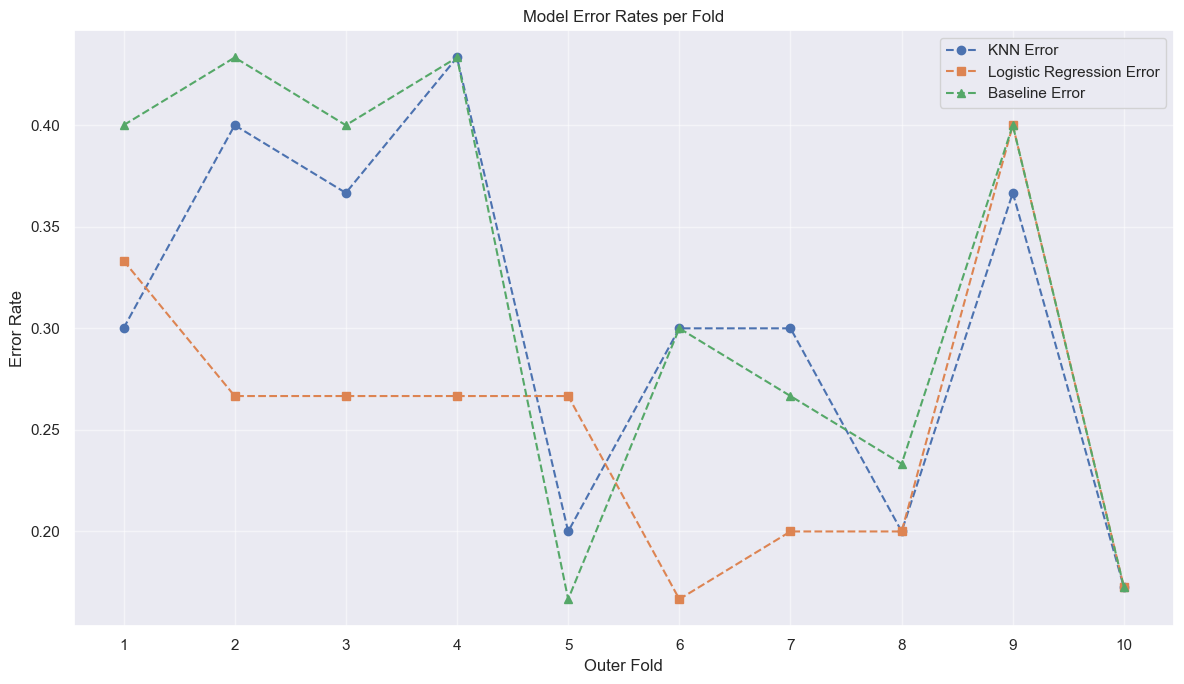

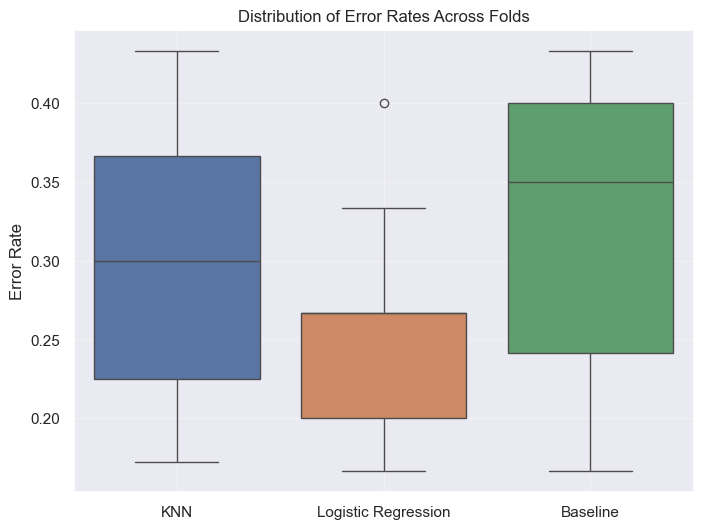

In [8]:
# Display the results table
print("Results from Nested Cross-Validation:")
display(results_df)

# --- Visualize Error Rates ---
plt.figure(figsize=(12, 7))

# Plot error rates per fold
plt.plot(results_df['Outer Fold'], results_df['KNN Error'], marker='o', linestyle='--', label='KNN Error')
plt.plot(results_df['Outer Fold'], results_df['LogReg Error'], marker='s', linestyle='--', label='Logistic Regression Error')
plt.plot(results_df['Outer Fold'], results_df['Baseline Error'], marker='^', linestyle='--', label='Baseline Error')

plt.title('Model Error Rates per Fold')
plt.xlabel('Outer Fold')
plt.ylabel('Error Rate')
plt.xticks(results_df['Outer Fold'])
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- Boxplot of Error Rates ---
plt.figure(figsize=(8, 6))
error_df = pd.DataFrame({
    'KNN': results_df['KNN Error'],
    'Logistic Regression': results_df['LogReg Error'],
    'Baseline': results_df['Baseline Error']
})
sns.boxplot(data=error_df)
plt.title('Distribution of Error Rates Across Folds')
plt.ylabel('Error Rate')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Calculate the mean error for each model across all folds
mean_knn_error = results_df['KNN Error'].mean()
mean_logreg_error = results_df['LogReg Error'].mean()
mean_baseline_error = results_df['Baseline Error'].mean()

print("--- Average Test Errors from Nested Cross-Validation ---")
print(f"Average KNN Error: {mean_knn_error:.4f}")
print(f"Average Logistic Regression Error: {mean_logreg_error:.4f}")
print(f"Average Baseline Error: {mean_baseline_error:.4f}")



--- Average Test Errors from Nested Cross-Validation ---
Average KNN Error: 0.3039
Average Logistic Regression Error: 0.2539
Average Baseline Error: 0.3206


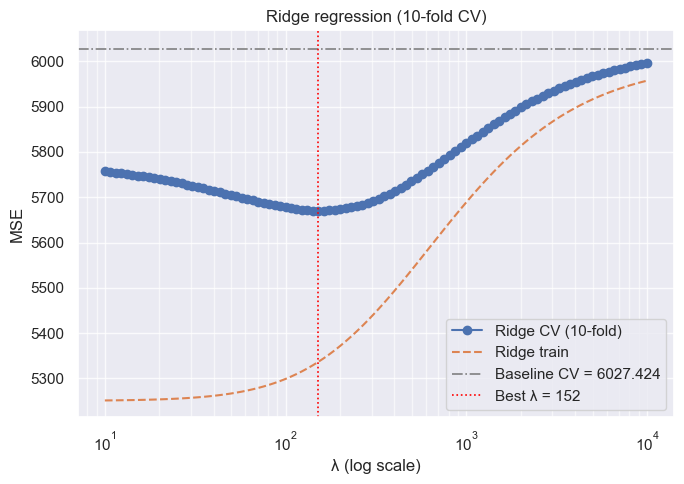

[none] λ* median=152 | mean outer=5670.3202 | baseline CV=6027.4238 | w0=130.2609


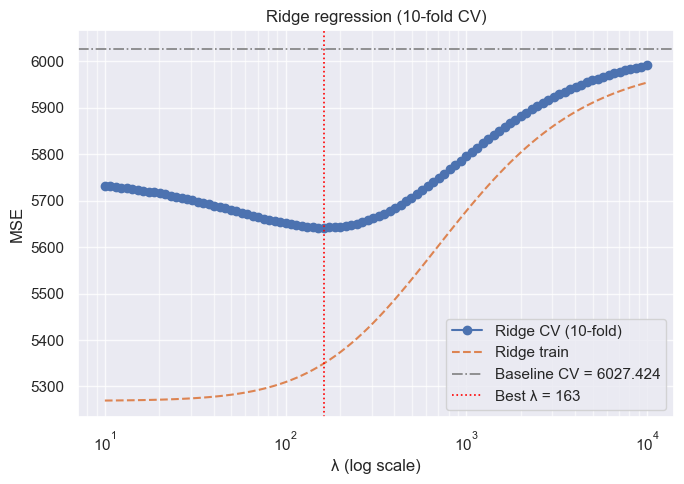

[log_cpk] λ* median=163 | mean outer=5642.1808 | baseline CV=6027.4238 | w0=130.2609


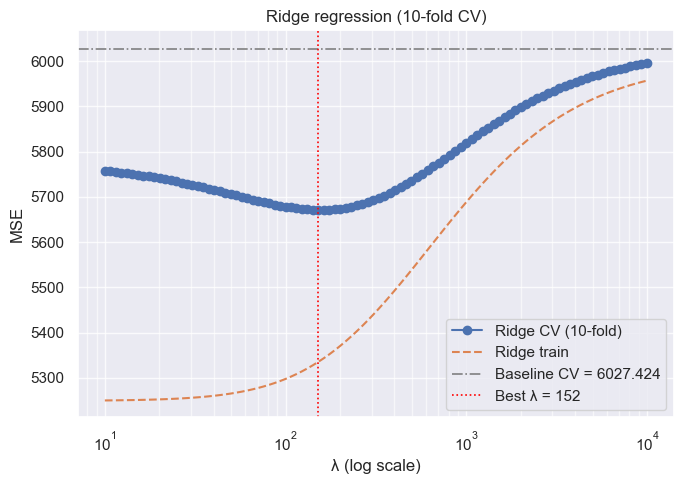

[sqrt_platelets] λ* median=152 | mean outer=5671.3802 | baseline CV=6027.4238 | w0=130.2609


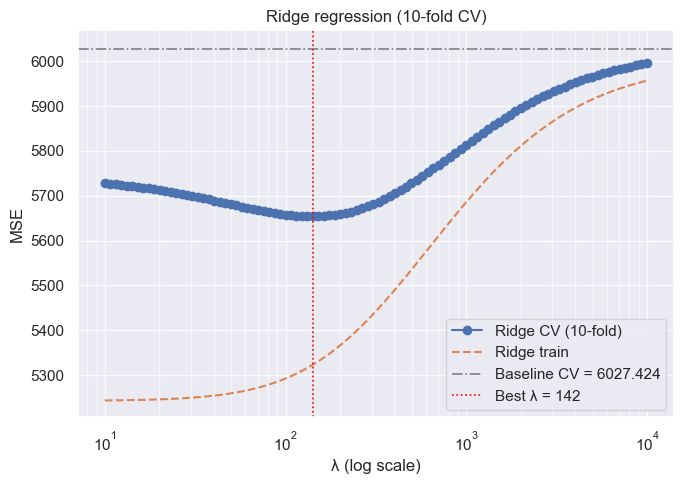

[recip_crea] λ* median=142 | mean outer=5653.9348 | baseline CV=6027.4238 | w0=130.2609


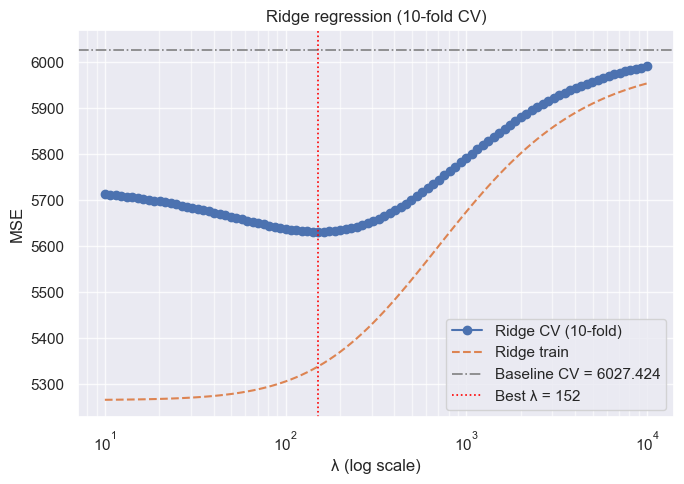

[all_three] λ* median=152 | mean outer=5631.3989 | baseline CV=6027.4238 | w0=130.2609

=== Coefficient comparison (all models + deltas, intercept included) ===
                                   none   log_cpk  sqrt_platelets  recip_crea  \
Feature                                                                         
Intercept (w0)                 130.2609  130.2609        130.2609    130.2609   
num__high_blood_pressure        -9.6523   -9.2074         -9.6238    -10.2139   
num__age                        -9.9013   -9.4591         -9.9170     -9.5713   
num__anaemia                    -6.8430   -5.9948         -6.8581     -7.2323   
num__serum_creatinine           -5.9667   -5.8054         -5.9801      6.5251   
num__serum_sodium                3.7702    3.5321          3.7869      3.6235   
num__creatinine_phosphokinase   -2.4493    2.8841         -2.4392     -2.7700   
num__ejection_fraction           2.1686    2.2977          2.1912      1.6732   
num__smoking                 

In [44]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



def run_ridge(df, target="time", metric="mse", lambdas=None, k_outer=10, k_inner=None,
              drop_extra=None, random_state=42, plot=True):
    """Ridge regression with optional nested CV — all numeric features standardized."""
    if lambdas is None:
        lambdas = np.logspace(-4, 4, 50)

    drop = [target] + (drop_extra or [])
    y = df[target].values
    X = df.drop(columns=drop, errors="ignore").copy()

    # --- all numeric standardized ---
    num = X.select_dtypes(include=[np.number]).columns
    pre = ColumnTransformer([("num", StandardScaler(), num)], remainder="drop")

    ridge = Pipeline([("pre", pre), ("m", Ridge(random_state=0))])
    base  = Pipeline([("pre", pre), ("m", DummyRegressor(strategy="mean"))])

    def m(y_t, y_p):
        if metric == "mae": return mean_absolute_error(y_t, y_p)
        if metric == "r2":  return r2_score(y_t, y_p)
        return mean_squared_error(y_t, y_p)

    hi = (metric == "r2")
    kf_outer = KFold(k_outer, shuffle=True, random_state=random_state)

    outer_scores, best_lambdas = [], []

    # ---------- SINGLE-CV MODE: build curves & global best ----------
    if k_inner is None:
        tr_curve, va_curve = [], []
        for l in lambdas:
            tr_f, va_f = [], []
            for tr_idx, va_idx in kf_outer.split(X):
                Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
                ytr, yva = y[tr_idx], y[va_idx]
                ridge.set_params(m__alpha=l).fit(Xtr, ytr)
                tr_f.append(m(ytr, ridge.predict(Xtr)))
                va_f.append(m(yva, ridge.predict(Xva)))
            tr_curve.append(np.mean(tr_f))
            va_curve.append(np.mean(va_f))
        tr_curve, va_curve = np.array(tr_curve), np.array(va_curve)
        best_global = lambdas[np.argmax(va_curve) if hi else np.argmin(va_curve)]
    # ----------------------------------------------------------------

    for train_idx, test_idx in kf_outer.split(X):
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y[train_idx], y[test_idx]

        if k_inner:  # nested CV: choose λ* on the training split
            kf_inner = KFold(k_inner, shuffle=True, random_state=random_state)
            inner_val = []
            for l in lambdas:
                fold_scores = []
                for i_tr, i_va in kf_inner.split(Xtr):
                    Xtr2, Xva2 = Xtr.iloc[i_tr], Xtr.iloc[i_va]
                    ytr2, yva2 = ytr[i_tr], ytr[i_va]
                    ridge.set_params(m__alpha=l).fit(Xtr2, ytr2)
                    fold_scores.append(m(yva2, ridge.predict(Xva2)))
                inner_val.append(np.mean(fold_scores))
            best = lambdas[np.argmax(inner_val) if hi else np.argmin(inner_val)]
        else:
            best = best_global  # reuse global best in single-CV mode

        ridge.set_params(m__alpha=best).fit(Xtr, ytr)
        outer_scores.append(m(yte, ridge.predict(Xte)))
        best_lambdas.append(best)

    mean_outer = float(np.mean(outer_scores))

    # --- baseline (same outer folds) ---
    bt, bv = [], []
    for i_tr, i_va in kf_outer.split(X):
        Xtr, Xva = X.iloc[i_tr], X.iloc[i_va]
        ytr, yva = y[i_tr], y[i_va]
        base.fit(Xtr, ytr)
        bt.append(m(ytr, base.predict(Xtr)))
        bv.append(m(yva, base.predict(Xva)))
    b_tr, b_va = float(np.mean(bt)), float(np.mean(bv))

    # --- plot (only in single-CV mode when we have curves) ---
    # --- plot (only in single-CV mode when we have curves) ---
    if plot and k_inner is None:
        plt.figure(figsize=(7, 5))
        plt.semilogx(lambdas, va_curve, 'o-', label=f"Ridge CV ({k_outer}-fold)")
        plt.semilogx(lambdas, tr_curve, '--', label="Ridge train")
        plt.axhline(b_va, color='gray', ls='-.', lw=1.2, label=f"Baseline CV = {b_va:.3f}")
        plt.axvline(best_global, color='red', ls=':', lw=1.2, label=f"Best λ = {best_global:.3g}")

        plt.xlabel("λ (log scale)")
        plt.ylabel(metric.upper())
        plt.title(f"Ridge regression ({k_outer}-fold CV)")
        
        # nice grid with both major and minor lines
        ax = plt.gca()
        ax.set_axisbelow(True)
        ax.grid(True, which="major",  alpha=0.8)
        ax.grid(True, which="minor",  alpha=0.6)
        
        # ensure baseline line is within visible limits
        ymin, ymax = ax.get_ylim()
        buffer = 0.05 * (ymax - ymin)
        plt.ylim(min(ymin, b_va - buffer), max(ymax, b_va + buffer))
        
        plt.legend()
        plt.tight_layout()
        plt.show()


    # --- final fit & coefficients (use median λ* across outer folds) ---
    ridge.set_params(m__alpha=float(np.median(best_lambdas))).fit(X, y)

    # feature names + weights + intercept
    feat_names = ridge.named_steps["pre"].get_feature_names_out().tolist()
    w = ridge.named_steps["m"].coef_
    w0 = float(ridge.named_steps["m"].intercept_)

    coefs = pd.DataFrame({"Feature": feat_names, "Coef": w}) \
            .sort_values(by="Coef", key=lambda s: s.abs(), ascending=False) \
            .reset_index(drop=True)

    # include intercept as first row for convenience
    coefs_with_w0 = pd.concat([
        pd.DataFrame([{"Feature": "Intercept (w0)", "Coef": w0}]),
        pd.DataFrame({"Feature": feat_names, "Coef": w})
    ], ignore_index=True)

    return {
        "outer_cv": int(k_outer),
        "inner_cv": int(k_inner) if k_inner else None,
        "mean_outer_score": mean_outer,
        "best_lambdas": list(best_lambdas),
        "baseline_train": b_tr,
        "baseline_cv": b_va,
        "intercept": w0,
        "coefs": coefs,                 # sorted by |w| (no intercept)
        "coefs_with_w0": coefs_with_w0, # includes intercept row
        "features_used": feat_names
    }

# ===== schemes & run loop =====
schemes = [
    ("none",          [0,0,0]),
    ("log_cpk",       [1,0,0]),
    ("sqrt_platelets",[0,1,0]),
    ("recip_crea",    [0,0,1]),
    ("all_three",     [1,1,1]),
]

results = {}
for name, scheme in schemes:
    X_transformed = df.copy()
    if scheme[0] == 1 and "creatinine_phosphokinase" in X_transformed:
        X_transformed['creatinine_phosphokinase'] = log(X_transformed['creatinine_phosphokinase'])
    if scheme[1] == 1 and "platelets" in X_transformed:
        X_transformed['platelets'] = sqrt(X_transformed['platelets'])
    if scheme[2] == 1 and "serum_creatinine" in X_transformed:
        X_transformed['serum_creatinine'] = reciprocal(X_transformed['serum_creatinine'])

    res = run_ridge(
        X_transformed, target="time", metric="mse",
        lambdas=np.logspace(1,4,100),
        k_outer=10,                   # set k_inner=3 if you want nested CV per scheme
        drop_extra=['DEATH_EVENT'],
        random_state=42, plot=True
    )
    results[name] = res
    print(f"[{name}] λ* median={np.median(res['best_lambdas']):.3g} | mean outer={res['mean_outer_score']:.4f} | baseline CV={res['baseline_cv']:.4f} | w0={res['intercept']:.4f}")

# ===== merge coefficients (with intercept row) =====
def coef_series_with_w0(runres, label):
    s = runres["coefs_with_w0"].set_index("Feature")["Coef"]
    s.name = label
    return s

coef_tab = pd.concat([coef_series_with_w0(results[name], name) for name, _ in schemes],
                     axis=1, join="outer").fillna(0.0)

# add Δ-columns vs baseline (none)
for name, _ in schemes:
    if name == "none": continue
    coef_tab[f"Δ_{name}"] = coef_tab[name] - coef_tab["none"]

# order rows by absolute size in 'all_three' (if present), otherwise by 'none'
sort_key = "all_three" if "all_three" in coef_tab.columns else "none"
coef_tab = coef_tab.reindex(coef_tab[sort_key].abs().sort_values(ascending=False).index)

# show: all model coefficients first, then deltas
coef_cols  = [name for name, _ in schemes]                 # ['none','log_cpk',...]
delta_cols = [f"Δ_{name}" for name, _ in schemes if name != "none"]
view_cols  = coef_cols + delta_cols

print("\n=== Coefficient comparison (all models + deltas, intercept included) ===")
print(coef_tab.loc[:, view_cols].round(4))


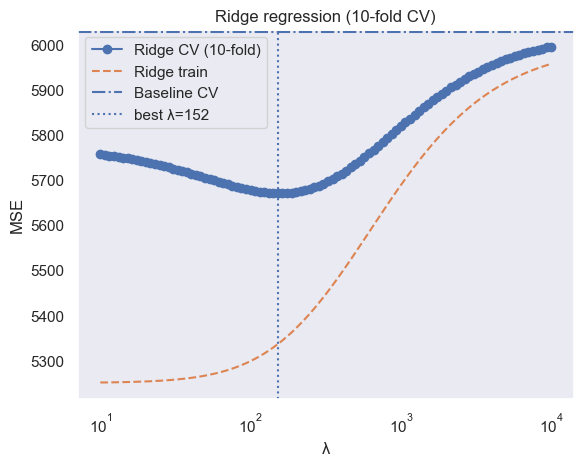

[none] best λ* median=152 | mean outer 5670.3202 | baseline CV 6027.4238


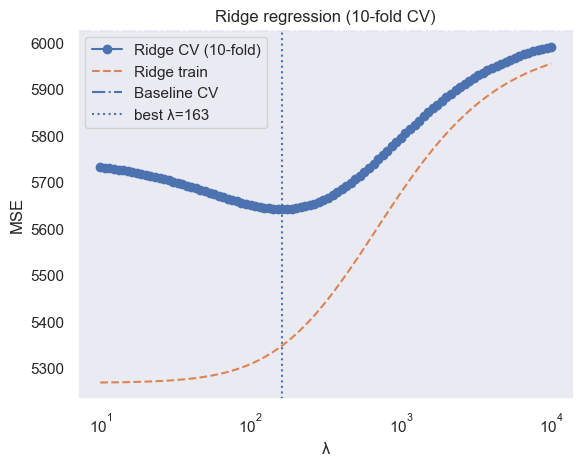

[log_cpk] best λ* median=163 | mean outer 5642.0846 | baseline CV 6027.4238


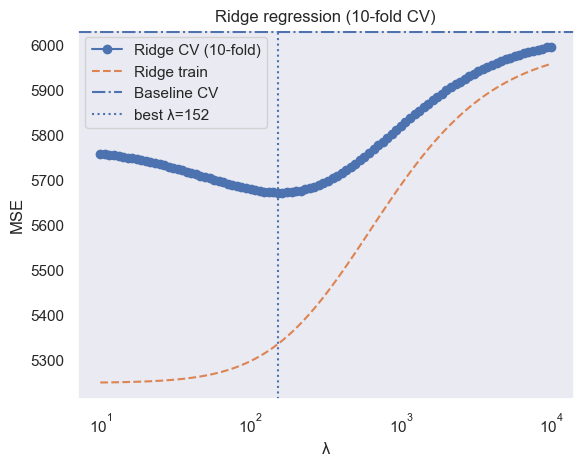

[sqrt_platelets] best λ* median=152 | mean outer 5671.3802 | baseline CV 6027.4238


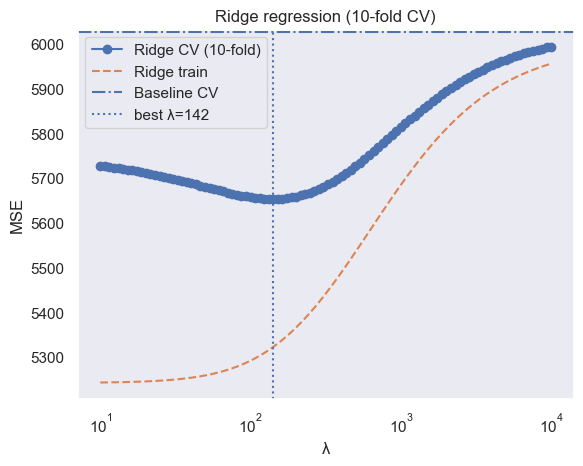

[recip_crea] best λ* median=142 | mean outer 5653.9347 | baseline CV 6027.4238


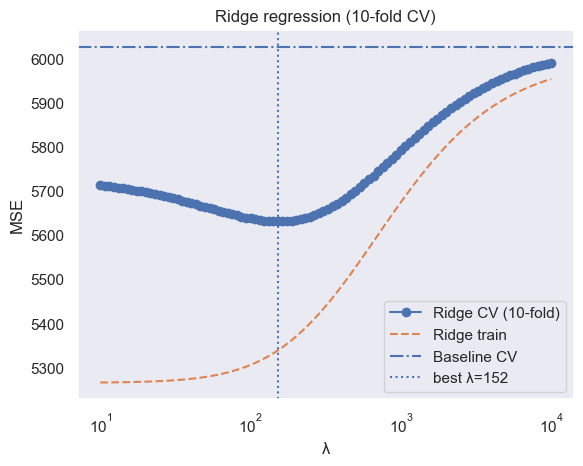

[all_three] best λ* median=152 | mean outer 5631.2920 | baseline CV 6027.4238

Full coefficient table:                                  none  log_cpk  sqrt_platelets  recip_crea  \
Feature                                                                      
num__age                      -9.9013  -9.4585         -9.9170     -9.5713   
num__high_blood_pressure      -9.6523  -9.2071         -9.6238    -10.2139   
num__anaemia                  -6.8430  -5.9941         -6.8581     -7.2323   
num__serum_creatinine         -5.9667  -5.8049         -5.9801      6.5251   
num__serum_sodium              3.7702   3.5319          3.7869      3.6235   
num__creatinine_phosphokinase -2.4493   2.8921         -2.4392     -2.7700   
num__ejection_fraction         2.1686   2.2984          2.1912      1.6732   
num__smoking                  -1.7021  -1.4921         -1.6735     -1.9117   
num__diabetes                  0.7525   0.7224          0.7815      0.9546   
num__sex                      -0.4602  